In [1]:
import syft as sy
import time
import numpy as np
import pandas as pd
from opacus import PrivacyEngine
from opacus.utils.uniform_sampler import UniformWithReplacementSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from collections import OrderedDict

In [2]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 8, 2, padding=3)
        self.conv2 = nn.Conv2d(16, 32, 4, 2)
        self.fc1 = nn.Linear(32 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = F.relu(self.conv1(x))  # -> [B, 16, 14, 14]
        x = F.max_pool2d(x, 2, 1)  # -> [B, 16, 13, 13]
        x = F.relu(self.conv2(x))  # -> [B, 32, 5, 5]
        x = F.max_pool2d(x, 2, 1)  # -> [B, 32, 4, 4]
        x = x.view(-1, 32 * 4 * 4)  # -> [B, 512]
        x = F.relu(self.fc1(x))  # -> [B, 32]
        x = self.fc2(x)  # -> [B, 10]
        return x

In [3]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    criterion = nn.CrossEntropyLoss()
    losses = []
    for _batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        epsilon, best_alpha = optimizer.privacy_engine.get_privacy_spent(1e-5)
        print(
            f"Train Epoch: {epoch} \t"
            f"Loss: {np.mean(losses):.6f} "
            f"(ε = {epsilon:.2f}, δ = 1e-5) for α = {best_alpha}"
        )

In [4]:
def test(model, device, test_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in (test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )
    return test_loss, correct / len(test_loader.dataset)

In [5]:
class MnistDataset(torch.utils.data.Dataset):
    def __init__(self, data_path):
        # data loading
        df = pd.read_csv(data_path, dtype=np.float64)
        self.x = torch.from_numpy(df.iloc[:,1:].values)
        
        self.x = self.x.reshape(self.x.size(0),1,28,28)
        self.x = self.x.float() # why float?
        
        self.y = torch.from_numpy(df.iloc[:,0].values) 
        self.y = self.y.long() # why long?
        
        self.n_samples = df.shape[0]
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [6]:
start = time.time()

train_dataset = MnistDataset("C:/Users/dells/dataset/.client_1_train_data.csv")
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_sampler=UniformWithReplacementSampler(
            num_samples=len(train_dataset),
            sample_rate=0.004,
        ),
    )

test_dataset = MnistDataset("C:/Users/dells/dataset/.client_1_test_data.csv")
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64,shuffle=True)

global_test = MnistDataset("C:/Users/dells/dataset/mnist_test.csv")
global_test_loader = torch.utils.data.DataLoader(dataset=global_test, batch_size=64,shuffle=True)

end = time.time()

In [7]:
print(f"Take dataset time: {float(end - start)} seconds")  

Take dataset time: 3.8077592849731445 seconds


In [8]:
start = time.time()

use_cuda = not False and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

end = time.time()

In [9]:
print(f"Check device time: {float(end - start)} seconds")  

Check device time: 0.2507305145263672 seconds


In [10]:
start = time.time()

model = Classifier().to(device)

end = time.time()

In [11]:
print(f"Create model time: {float(end - start)} seconds")

Create model time: 5.198504209518433 seconds


In [12]:
start = time.time()
optimizerLR = optim.SGD(model.parameters(), lr=0.01, momentum=0)
model.train()
privacy_engine = PrivacyEngine(
                model,
                sample_rate=0.004,
                alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
                noise_multiplier=1.0,
                max_grad_norm=1.0,
            )
privacy_engine.attach(optimizerLR)
end = time.time()

C:\Users\dells\anaconda3\lib\site-packages\opacus\privacy_engine.py:645: UserWarning: A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
  warnings.warn(
C:\Users\dells\anaconda3\lib\site-packages\opacus\privacy_engine.py:229: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  warnings.warn(


In [13]:
print(f"Attach DP module into optimizer: {float(end - start)} seconds")

Attach DP module into optimizer: 0.00599980354309082 seconds


In [340]:
start = time.time()

for epoch in range(1, 11):
    train(model, device, train_loader, optimizerLR, epoch)
    test(model, device, test_loader)
    
end = time.time()

C:\Users\dells\anaconda3\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [341]:
print(f"Training time: {float(end - start)} seconds")  

Training time: 123.29391264915466 seconds


In [342]:
start = time.time()

torch.save(model.state_dict(), "mnist_ann1.pt")

end = time.time()

In [343]:
print(f"Saving time: {float(end - start)} seconds")  

Saving time: 0.0033423900604248047 seconds


In [344]:
start = time.time()

load_model = torch.load('mnist_ann1.pt')

end = time.time()

In [345]:
print(f"Load params time: {float(end - start)} seconds")

Load params time: 0.012264013290405273 seconds


In [346]:
start = time.time()

conv1_weight = load_model["conv1.weight"].tolist()
conv1_bias = load_model["conv1.bias"].tolist()

conv2_weight = load_model["conv2.weight"].tolist()
conv2_bias = load_model["conv2.bias"].tolist()

fc1_weight = load_model["fc1.weight"].tolist()
fc1_bias = load_model["fc1.bias"].tolist()

fc2_weight = load_model["fc2.weight"].tolist()
fc2_bias = load_model["fc2.bias"].tolist()

end = time.time()

In [347]:
print(f"Take w+b time: {float(end - start)} seconds")

Take w+b time: 0.007004976272583008 seconds


### Establish connection

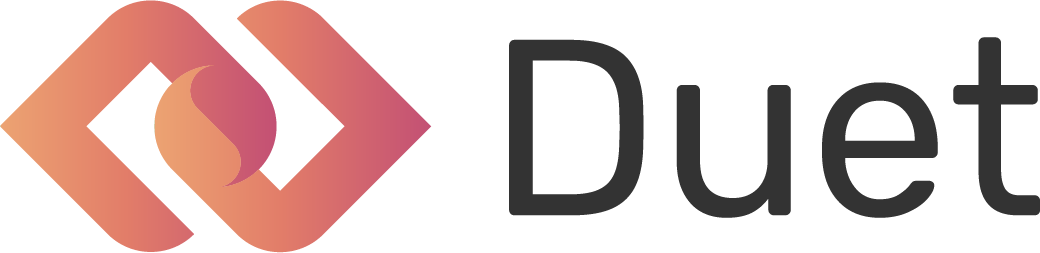

In [352]:
duet = sy.launch_duet(loopback=True)

In [353]:
start = time.time()

conv1_weight_ptr = sy.lib.python.List(conv1_weight).send(duet, pointable=True, tags=["conv1_weight"])
conv1_bias_ptr = sy.lib.python.List(conv1_bias).send(duet, pointable=True, tags=["conv1_bias"])
conv2_weight_ptr = sy.lib.python.List(conv2_weight).send(duet, pointable=True, tags=["conv2_weight"])
conv2_bias_ptr = sy.lib.python.List(conv2_bias).send(duet, pointable=True, tags=["conv2_bias"])
fc1_weight_ptr = sy.lib.python.List(fc1_weight).send(duet, pointable=True, tags=["fc1_weight"])
fc1_bias_ptr = sy.lib.python.List(fc1_bias).send(duet, pointable=True, tags=["fc1_bias"])
fc2_weight_ptr = sy.lib.python.List(fc2_weight).send(duet, pointable=True, tags=["fc2_weight"])
fc2_bias_ptr = sy.lib.python.List(fc2_bias).send(duet, pointable=True, tags=["fc2_bias"])

end = time.time()

In [354]:
print(f"Send params time: {float(end - start)} seconds")

Send params time: 4.975216865539551 seconds


In [355]:
duet.store.pandas

,ID,Tags,Description,object_type
0,<UID: 883883fbd8314ca0a6924779bd37b915>,[conv1_weight],,<class 'syft.lib.python.list.List'>
1,<UID: 8edbc4ee11f24d35860844fcf65711ee>,[conv1_bias],,<class 'syft.lib.python.list.List'>
2,<UID: 6e2213ba0a5e44bf8f027d6f3106b2a9>,[conv2_weight],,<class 'syft.lib.python.list.List'>
3,<UID: 9cfc112b7b0d417692b7f41b7f1ae034>,[conv2_bias],,<class 'syft.lib.python.list.List'>
4,<UID: 3a4611d827ad4b9b82bd0894693942a0>,[fc1_weight],,<class 'syft.lib.python.list.List'>
5,<UID: 06bcae753e944ca1a4ad00f3554b2960>,[fc1_bias],,<class 'syft.lib.python.list.List'>
6,<UID: 815698d736e74e3f96b83f5d136085a8>,[fc2_weight],,<class 'syft.lib.python.list.List'>
7,<UID: 076e6c16dd174d1b9a34e9defefa5270>,[fc2_bias],,<class 'syft.lib.python.list.List'>


### Checkpoint 0

In [356]:
duet.requests.pandas

,Requested Object's tags,Reason,Request ID,Requested Object's ID,Requested Object's type
0,[conv1_weight],I would like to get the conv1 weight,<UID: 137a5a3ba9de48879f564dad02812cec>,<UID: 883883fbd8314ca0a6924779bd37b915>,<class 'syft.lib.python.list.List'>
1,[conv1_bias],I would like to get the conv1 bias,<UID: 6c66bbe0bb864152a0ec1deb5eb241c1>,<UID: 8edbc4ee11f24d35860844fcf65711ee>,<class 'syft.lib.python.list.List'>
2,[conv2_weight],I would like to get the conv2 weight,<UID: 16d73b217caa44eb95de96cd666fb9ce>,<UID: 6e2213ba0a5e44bf8f027d6f3106b2a9>,<class 'syft.lib.python.list.List'>
3,[conv2_bias],I would like to get the conv2 bias,<UID: cfc16f61b4ad416a944ebea99969f4b3>,<UID: 9cfc112b7b0d417692b7f41b7f1ae034>,<class 'syft.lib.python.list.List'>
4,[fc1_weight],I would like to get the fc1 weight,<UID: 9af98a78d46641e7943a378e09ba1068>,<UID: 3a4611d827ad4b9b82bd0894693942a0>,<class 'syft.lib.python.list.List'>
5,[fc1_bias],I would like to get the fc1 bias,<UID: a24e7075b21042218815b382165f5256>,<UID: 06bcae753e944ca1a4ad00f3554b2960>,<class 'syft.lib.python.list.List'>
6,[fc2_weight],I would like to get the fc2 weight,<UID: 844587bcb0d449ce8751addbda5b9283>,<UID: 815698d736e74e3f96b83f5d136085a8>,<class 'syft.lib.python.list.List'>
7,[fc2_bias],I would like to get the fc2 bias,<UID: a218edcf70bc49458abfab82b5f46111>,<UID: 076e6c16dd174d1b9a34e9defefa5270>,<class 'syft.lib.python.list.List'>


In [357]:
duet.requests[0].accept()
duet.requests[0].accept()
duet.requests[0].accept()
duet.requests[0].accept()
duet.requests[0].accept()
duet.requests[0].accept()
duet.requests[0].accept()
duet.requests[0].accept()

### Checkpoint 1

In [358]:
duet.store.pandas

,ID,Tags,Description,object_type
0,<UID: cf3555e0a8e74b539ac50b9ff7360a51>,[global_conv1_weight],,<class 'syft.lib.python.list.List'>
1,<UID: 74b2efa9bcb14588b8c720debfade240>,[global_conv1_bias],,<class 'syft.lib.python.list.List'>
2,<UID: 80c0c3228a434651a604532568f89f23>,[global_conv2_weight],,<class 'syft.lib.python.list.List'>
3,<UID: 5460b19723634fbcb76600b5067fe390>,[global_conv2_bias],,<class 'syft.lib.python.list.List'>
4,<UID: 0d0a16526a864718860fd2f76d5508a5>,[global_fc1_weight],,<class 'syft.lib.python.list.List'>
5,<UID: 1a1887e7225a40099dce4236a450e7f4>,[global_fc1_bias],,<class 'syft.lib.python.list.List'>
6,<UID: 726590e2cd444185b767637257ddef9b>,[global_fc2_weight],,<class 'syft.lib.python.list.List'>
7,<UID: fab2cd69a0f74ee98c94553654738f75>,[global_fc2_bias],,<class 'syft.lib.python.list.List'>


In [359]:
start = time.time()

updated_conv1_weight = duet.store["global_conv1_weight"].get()
updated_conv1_bias = duet.store["global_conv1_bias"].get()
updated_conv2_weight = duet.store["global_conv2_weight"].get()
updated_conv2_bias = duet.store["global_conv2_bias"].get()
updated_fc1_weight = duet.store["global_fc1_weight"].get()
updated_fc1_bias = duet.store["global_fc1_bias"].get()
updated_fc2_weight = duet.store["global_fc2_weight"].get()
updated_fc2_bias = duet.store["global_fc2_bias"].get()

end = time.time()

In [360]:
print(f"Get time: {float(end - start)} seconds")

Get time: 7.341887950897217 seconds


In [361]:
start = time.time()

avg_updates = OrderedDict()
avg_updates["conv1.weight"] = torch.Tensor(updated_conv1_weight)
avg_updates["conv1.bias"] = torch.Tensor(updated_conv1_bias)
avg_updates["conv2.weight"] = torch.Tensor(updated_conv2_weight)
avg_updates["conv2.bias"] = torch.Tensor(updated_conv2_bias)
avg_updates["fc1.weight"] = torch.Tensor(updated_fc1_weight)
avg_updates["fc1.bias"] = torch.Tensor(updated_fc1_bias)
avg_updates["fc2.weight"] = torch.Tensor(updated_fc2_weight)
avg_updates["fc2.bias"] = torch.Tensor(updated_fc2_bias)

end = time.time()

In [362]:
print(f"Create params time: {float(end - start)} seconds")

Create params time: 1.277759075164795 seconds


In [363]:
start = time.time()

model.load_state_dict(avg_updates)

end = time.time()

In [364]:
print(f"Load model time: {float(end - start)} seconds")

In [37]:
l1, test1 =test(model, device, global_test_loader)
l1, test1


Test set: Average loss: 0.0678, Accuracy: 1108/10000 (11.08%)



(0.06775185844898224, 0.1108)

In [63]:
l2, test2 =test(model, device, global_test_loader)
l2, test2

(0.0067995513923466205, 0.8972)

In [85]:
l3, test3 =test(model, device, global_test_loader)
l3, test3

(0.0057579697800800205, 0.9263)

Exception in callback Transaction.__retry()
handle: <TimerHandle when=3231.625 Transaction.__retry()>
Traceback (most recent call last):
  File "C:\Users\dells\anaconda3\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dells\anaconda3\lib\site-packages\aioice\stun.py", line 306, in __retry
    self.__future.set_exception(TransactionTimeout())
  File "C:\Users\dells\anaconda3\lib\asyncio\futures.py", line 246, in set_exception
    raise exceptions.InvalidStateError(f'{self._state}: {self!r}')
asyncio.exceptions.InvalidStateError: FINISHED: <Future finished result=(Message(messa...*\xe3\xcaO\t'), ('192.168.2.1', 54350))>


In [111]:
l4 ,test4 =test(model, device, global_test_loader)
l4 ,test4

(0.005155868857167662, 0.9395)

Exception in callback Transaction.__retry()
handle: <TimerHandle when=3849.687 Transaction.__retry()>
Traceback (most recent call last):
  File "C:\Users\dells\anaconda3\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dells\anaconda3\lib\site-packages\aioice\stun.py", line 306, in __retry
    self.__future.set_exception(TransactionTimeout())
  File "C:\Users\dells\anaconda3\lib\asyncio\futures.py", line 246, in set_exception
    raise exceptions.InvalidStateError(f'{self._state}: {self!r}')
asyncio.exceptions.InvalidStateError: FINISHED: <Future finished result=(Message(messa...x17\x9c3\xe7'), ('192.168.2.1', 50209))>


In [133]:
l5 ,test5 =test(model, device, global_test_loader)
l5 ,test5

(0.004727325099520385, 0.9457)

In [155]:
l6 ,test6 =test(model, device, global_test_loader)
l6 ,test6

(0.004405974704748951, 0.9506)

Exception in callback Transaction.__retry()
handle: <TimerHandle when=4789.25 Transaction.__retry()>
Traceback (most recent call last):
  File "C:\Users\dells\anaconda3\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dells\anaconda3\lib\site-packages\aioice\stun.py", line 306, in __retry
    self.__future.set_exception(TransactionTimeout())
  File "C:\Users\dells\anaconda3\lib\asyncio\futures.py", line 246, in set_exception
    raise exceptions.InvalidStateError(f'{self._state}: {self!r}')
asyncio.exceptions.InvalidStateError: FINISHED: <Future finished result=(Message(messa...xa8"\x1a\x0f'), ('192.168.2.1', 64490))>


In [177]:
l7 ,test7 =test(model, device, global_test_loader)
l7 ,test7

(0.004064303783443756, 0.9549)

In [207]:
l8 ,test8 =test(model, device, global_test_loader)
l8 ,test8

(0.0038982562967692504, 0.9566)

In [229]:
l9 ,test9 =test(model, device, global_test_loader)
l9 ,test9

♫♫♫ > DUET LIVE STATUS  -  Objects: 0  Requests: 0   Messages: 77  Request Handlers: 0                                

(0.0038573820145917123, 0.9577)

In [251]:
l10 ,test10 =test(model, device, global_test_loader)
l10 ,test10

♫♫♫ > DUET LIVE STATUS  *  Objects: 0  Requests: 0   Messages: 78  Request Handlers: 0                                

(0.003677843551361002, 0.9609)

In [273]:
l11 ,test11 =test(model, device, global_test_loader)
l11 ,test11

(0.0035038088591070847, 0.9646)

Exception in callback Transaction.__retry()
handle: <TimerHandle when=7231.562 Transaction.__retry()>
Traceback (most recent call last):
  File "C:\Users\dells\anaconda3\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dells\anaconda3\lib\site-packages\aioice\stun.py", line 306, in __retry
    self.__future.set_exception(TransactionTimeout())
  File "C:\Users\dells\anaconda3\lib\asyncio\futures.py", line 246, in set_exception
    raise exceptions.InvalidStateError(f'{self._state}: {self!r}')
asyncio.exceptions.InvalidStateError: FINISHED: <Future finished result=(Message(messa...x84\xe1\xb3,'), ('192.168.2.1', 54033))>


In [295]:
l12 ,test12 =test(model, device, global_test_loader)
l12 ,test12

(0.003423455767147243, 0.9647)

Exception in callback Transaction.__retry()
handle: <TimerHandle when=7737.421 Transaction.__retry()>
Traceback (most recent call last):
  File "C:\Users\dells\anaconda3\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dells\anaconda3\lib\site-packages\aioice\stun.py", line 306, in __retry
    self.__future.set_exception(TransactionTimeout())
  File "C:\Users\dells\anaconda3\lib\asyncio\futures.py", line 246, in set_exception
    raise exceptions.InvalidStateError(f'{self._state}: {self!r}')
asyncio.exceptions.InvalidStateError: FINISHED: <Future finished result=(Message(messa...\xaa\x16\xb0'), ('192.168.2.1', 63658))>


In [317]:
l13 ,test13 =test(model, device, global_test_loader)
l13 ,test13

(0.0033451404131238293, 0.9654)

In [339]:
l14 ,test14 =test(model, device, global_test_loader)
l14 ,test14

(0.0033226429660952817, 0.966)

In [365]:
l15 ,test15 =test(model, device, global_test_loader)
l15 ,test15

(0.0032557061222396443, 0.9659)

Exception in callback Transaction.__retry()
handle: <TimerHandle when=9544.218 Transaction.__retry()>
Traceback (most recent call last):
  File "C:\Users\dells\anaconda3\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dells\anaconda3\lib\site-packages\aioice\stun.py", line 306, in __retry
    self.__future.set_exception(TransactionTimeout())
  File "C:\Users\dells\anaconda3\lib\asyncio\futures.py", line 246, in set_exception
    raise exceptions.InvalidStateError(f'{self._state}: {self!r}')
asyncio.exceptions.InvalidStateError: FINISHED: <Future finished result=(Message(messa...x14\x12T\xb8'), ('192.168.2.1', 57677))>
